In [21]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm

%matplotlib inline

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
#задаем классы изображений
kaggle_input_directory = '/kaggle/input/food-101/food-101/food-101/images/'
classes = os.listdir(kaggle_input_directory)
#путь до изображений
PATH = '/kaggle/input/food-101/food-101/food-101/images/'

In [24]:
transform = transforms.Compose(
    [transforms.Resize((64,64)),  #изменим размер изображений
     transforms.ToTensor(),   #переведем в формат который необходим нейронной сети - тензор
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])]) # проведем нормализацию изображения

#загружаем тренировочный и тестовый датасеты
trainset = torchvision.datasets.ImageFolder(PATH, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, num_workers=0, shuffle=True)

# Создайте набор данных
testset = torchvision.datasets.ImageFolder(PATH, transform=transform)

# Определите ограниченное количество элементов
num_samples = 100
indices = torch.randperm(len(testset))[:num_samples]

# Создайте подмножество с ограниченным количеством элементов
subset_data = Subset(testset, indices)

# Создайте загрузчик данных
testloader = DataLoader(subset_data, batch_size=64, num_workers=0, shuffle=True)

In [25]:
def image_shower(images, labels, n=4):
    plt.figure(figsize=(12, 12))
    for i, image in enumerate(images[:n]):
        plt.subplot(n, n, i + 1)
        image = image/ 2 + 0.5
        plt.imshow(image.numpy().transpose((1, 2, 0)).squeeze())
    print("Real Labels: ", ' '.join('%5s' % classes[label] for label in labels[:n]))

Real Labels:  takoyaki hamburger chicken_curry creme_brulee


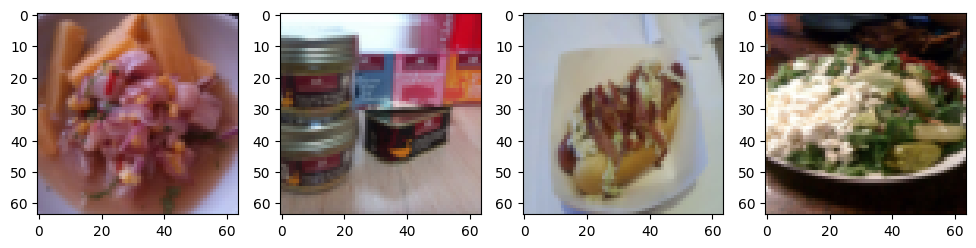

In [26]:
images, labels = next(iter(trainloader))
image_shower(images, labels)

In [27]:
model = torchvision.models.resnet50(pretrained=True)
#заморозим веса
for param in model.parameters():
    param.require = False

model.fc = nn.Linear(2048, len(classes))

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [29]:
epochs = 9   #количество эпох (сколько раз будем тренировать)
model.to(device) #переносим нашу модель на GPU

for epoch in range(epochs):
    running_loss = 0.0
    #теперь в цикле проходим по нашему загрузчику данных
    for i, data in tqdm(enumerate(trainloader)):
        #каждый батч тоже помещаем на GPU
        inputs, labels = data[0].to(device), data[1].to(device)
        #сбрасываем накопленный градиент 
        optimizer.zero_grad()
        #прогоняем изображения через модель, чтобы получить предсказание
        outputs = model(inputs)
        #рассчитываем функцию потерь (насколько хорошо предсказали)
        loss = criterion(outputs, labels)
        #считаем градиенты (обратный проход)
        loss.backward()
        #делаем шаг оптимизатора (обновляем веса)
        optimizer.step()

        running_loss += loss.item()

    print ("Epoch {} - Training loss: {} ".format(epoch, running_loss/len(trainloader)))

1579it [09:57,  2.64it/s]


Epoch 0 - Training loss: 3.26967955828468 


1579it [09:52,  2.67it/s]


Epoch 1 - Training loss: 2.4455848381140326 


1579it [10:23,  2.53it/s]


Epoch 2 - Training loss: 2.0814106606319784 


1579it [10:25,  2.52it/s]


Epoch 3 - Training loss: 1.7605753021197956 


1579it [10:33,  2.49it/s]


Epoch 4 - Training loss: 1.4478429902045316 


1579it [10:28,  2.51it/s]


Epoch 5 - Training loss: 1.1521488933943735 


1579it [10:29,  2.51it/s]


Epoch 6 - Training loss: 0.9569470214647459 


1579it [10:20,  2.55it/s]


Epoch 7 - Training loss: 0.6004693047146468 


1579it [10:11,  2.58it/s]

Epoch 8 - Training loss: 0.45249014890424205 


In [30]:
correct = 0
total = 0
with torch.no_grad():
    #переводим модель в режим инференса
    model.eval()
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        #получаем наши предсказания
        _, predicted = torch.max(outputs.data, 1)
        #посчитаем общее количество картинок
        total += labels.size(0)
        #посчитаем количество точно классифицированных картинок
        correct += (predicted == labels).sum().item()
print("Accuracy: %d" %(100 * correct/total))

Accuracy: 88


Real Labels:  crab_cakes bread_pudding nachos huevos_rancheros
Predicted:  crab_cakes bread_pudding nachos huevos_rancheros


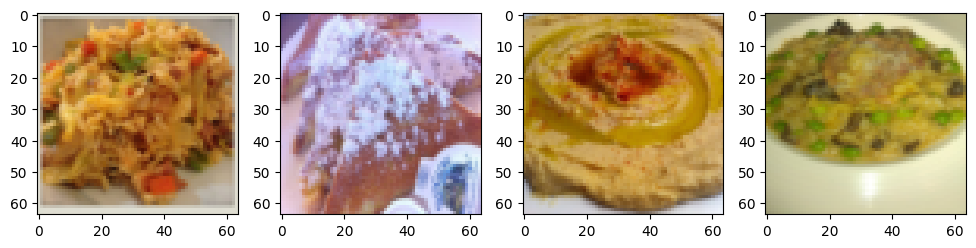

In [31]:
images, labels = next(iter(testloader))
image_shower(images, labels)

outputs = model(images.to(device))

_, predicted = torch.max(outputs, 1)

print("Predicted: ", " ".join("%5s" %classes[predict] for predict in predicted[:4]))

In [32]:
torch.save(model.state_dict(), '/kaggle/working/model2.pt')